In [0]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Read input video

In [0]:
%%shell
cd '/content/drive/My Drive/636/sample_part5/video/'
ffmpeg -i sample_1.mp4 -ss 00:41 -t 15 1.mp4
ffmpeg -i sample_2.mp4 -ss 00:00 -t 15 2.mp4
ffmpeg -i sample_3.mp4 -ss 00:00 -t 15 3.mp4
ffmpeg -i sample_4.mp4 -ss 00:03 -t 15 4.mp4

ffmpeg version 3.4.6-0ubuntu0.18.04.1 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.3.0-16ubuntu3)
  configuration: --prefix=/usr --extra-version=0ubuntu0.18.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --ena

Use openpose to generate frames

In [0]:
import os
from os.path import exists, join, basename, splitext

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
if not exists(project_name):
  # see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
  # install new CMake becaue of CUDA10
  !wget -q https://cmake.org/files/v3.13/cmake-3.13.0-Linux-x86_64.tar.gz
  !tar xfz cmake-3.13.0-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local
  # clone openpose
  !git clone -q --depth 1 $git_repo_url
  !sed -i 's/execute_process(COMMAND git checkout master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
  # install system dependencies
  !apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev
  # install python dependencies
  !pip install -q youtube-dl
  # build openpose
  !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
  
from IPython.display import YouTubeVideo

Generate facial landmarks input from frames

In [0]:
!mkdir -p ./openpose/output/2
!mkdir -p ./openpose/output/3
!mkdir -p ./openpose/output/4
!mkdir -p ./openpose/output/1
!cd openpose && ./build/examples/openpose/openpose.bin --video ../2.mp4 --write_json output/2/ --display 0 --render_pose 0 --face
!cd openpose && ./build/examples/openpose/openpose.bin --video ../3.mp4 --write_json output/3/ --display 0 --render_pose 0 --face
!cd openpose && ./build/examples/openpose/openpose.bin --video ../4.mp4 --write_json output/4/ --display 0 --render_pose 0 --face
!cd openpose && ./build/examples/openpose/openpose.bin --video ../1.mp4 --write_json output/1/ --display 0 --render_pose 0 --face

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 35.309576 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 88.304749 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 54.201476 seconds.
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 40.485622 seconds.


In [0]:
!mkdir -p ./openpose/output/5
!cd openpose && ./build/examples/openpose/openpose.bin --video ../5.mp4 --write_json output/5/ --display 0 --render_pose 0 --face

Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 54.569424 seconds.


In [0]:
import json
import pandas as pd
import numpy as np
import os, os.path
import csv

In [0]:
N_FACE = 70
N_POSE = 8
FOLDER = './openpose/output/'
CSV_FOLDER = './drive/My Drive/636/sample_part5/res/'
MODEL_FOLDER = './drive/My Drive/636/model/'
COL_NAMES = ['vid', 'frame']
COL_NAMES += ['f_' + str(i) for i in range(N_FACE * 2)]
COL_NAMES += ['p_' + str(i) for i in range(N_POSE * 2)]
droplist_f = set([(i * 3 + 2) for i in range(N_FACE)])
droplist_p = set([(i * 3 + 2) for i in range(N_POSE)])
idx_f = [i for i in range(N_FACE * 3) if (i not in droplist_f)]
idx_p = [i for i in range(N_POSE * 3) if (i not in droplist_p)]

In [0]:
# # collect the json output of openpose and combine them into csv
# def json_to_csv(folderpath, csv_path, vid):

#   idx = 0
#   write_file = open(csv_path, 'w')
#   csv_writer = csv.writer(write_file)
#   csv_writer.writerow(COL_NAMES) 
#   for name in sorted(os.listdir(folderpath)): 
#     if name[-4:] == 'json':
#       filepath = os.path.join(folderpath, name)
#       if os.path.isfile(filepath):
#         with open(filepath, 'r') as f:
#           data = json.load(f)['people']
#           if len(data) > 0:
#             row = [vid, name]
#             row_face = [float(data[0]['face_keypoints_2d'][j]) for j in idx_f]
#             row_pose = [float(data[0]['pose_keypoints_2d'][j]) for j in idx_p]
#             row += row_face + row_pose
#             row = np.array(row)
#             csv_writer.writerow(row)
#       idx += 1

# def get_csv(i):
#   folderpath = FOLDER + str(i) + '/'
#   csv_path = CSV_FOLDER + str(i) + '.csv'
#   json_to_csv(folderpath, csv_path, i)

# for i in range(1, 6):
#   get_csv(i)

In [0]:
# for use now
df_list = []
for i in range(1, 6):
  df = pd.read_csv(CSV_FOLDER + str(i) + '.csv')
  df_list.append(df)

In [0]:
for i in range(5):
  df_list[i] = df_list[i][df_list[i].columns[2:]]

In [0]:
df_list

[         f_0      f_1      f_2      f_3  ...  p_12  p_13  p_14  p_15
 0    608.104  182.533  605.245  218.262  ...   0.0   0.0   0.0   0.0
 1    601.576  177.755  595.971  214.185  ...   0.0   0.0   0.0   0.0
 2    593.186  178.170  588.916  216.601  ...   0.0   0.0   0.0   0.0
 3    591.117  173.803  586.904  208.908  ...   0.0   0.0   0.0   0.0
 4    584.937  173.060  582.150  209.282  ...   0.0   0.0   0.0   0.0
 ..       ...      ...      ...      ...  ...   ...   ...   ...   ...
 349  590.188  183.864  555.773  258.128  ...   0.0   0.0   0.0   0.0
 350  580.039  184.403  539.941  255.488  ...   0.0   0.0   0.0   0.0
 351  556.902  183.543  510.500  248.927  ...   0.0   0.0   0.0   0.0
 352  563.328  185.735  523.478  260.001  ...   0.0   0.0   0.0   0.0
 353    0.000    0.000    0.000    0.000  ...   0.0   0.0   0.0   0.0
 
 [354 rows x 156 columns],
             f_0      f_1         f_2  ...     p_13     p_14     p_15
 0    150.909000  116.604  151.716000  ...    0.000    0.000 

Reshape Data into Segments and Prepare for Keras

In [0]:
# slice every 10 frame as a segment until the last frame reaches the end
def get_segments_and_timestamps(df, fps, STEP):
  slices = []
  ts = []
  size = df.shape[0]
  i = STEP
  if size >= STEP:
    while i <= size:
      if i >= STEP:
        slices.append(df.values[df.index[i - STEP : i]])
        ts.append(i/fps)
      i += 1
  else:
    slice_ = df.values
    fillzero = np.zeros((STEP - size, N_FEATURES))
    slice_ = np.concatenate((slice_, fillzero), axis=0)
    slices.append(slice_)
  slices_arr = np.asarray(slices, dtype= np.float32)
  ts_arr = np.asarray(ts, dtype= np.float32)
  return slices_arr, ts_arr

# # slice every TIME_STEP frame as a segment until from 1st frame to last, if null, make up with 0
# def get_slices(df, fps, TIME_STEP):
#   slices = []
#   ts = []
#   index_arr = 
#   for i in index_arr:
#     if i + 1 < TIME_STEP:
#       slice_ = df.values[df.index[0 : i + 1]]
#       fillzero = np.zeros((TIME_STEP - i - 1, N_FEATURES))
#       slice_ = np.concatenate((slice_, fillzero), axis=0)
#       slices.append(slice_)
#     else:
#       slices.append(df.values[df.index[i + 1 - TIME_STEP : i + 1]])

#   slices_arr = np.asarray(slices, dtype= np.float32)
#   return slices_arr

Load model and weight

In [0]:
%tensorflow_version 1.x
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, LSTM, LSTM, Dropout, Flatten
from keras.callbacks import History, EarlyStopping
from keras.models import load_model

TensorFlow 1.x selected.


Using TensorFlow backend.


Draw figure

In [0]:
import matplotlib.pyplot as plt
from google.colab import files

def drawplt(time, pred):
  plt.figure(figsize=(15,10))
  # plt.plot(time, pred, 'b', label='prediction', markersize=1)
  plt.plot(time, pred, 'bo', label='prediction', markersize=3, color='red')
  plt.title('Prediction over time')
  plt.legend()
  plt.show()

Generate json

In [0]:
import json
def to_json(filepath):
  np_pred = np.array((ts_arr, y_pred.flatten())).T
  pred_list = np_pred.tolist()
  pred_dict = {"cry":pred_list}
  pred_json = json.dumps(pred_dict)
  with open(filepath, 'w') as json_file:
    json_file.write(pred_json)

Automation

In [0]:
model = load_model('bi_adam.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_segments_and_timestamps(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  drawplt(ts_arr, y_pred)
  # output json file
  json_name = 'sample_' + str(i + 1) + '.json'
  to_json(CSV_FOLDER + json_name)

In [0]:
model = load_model('bi_adam_new.h5')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  X_arr, ts_arr = get_segments_and_timestamps(df, 30, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  drawplt(ts_arr, y_pred)
  # output json file
  json_name = 'bi_adam_new_sample_' + str(i + 1) + '.json'
  to_json(CSV_FOLDER + json_name)

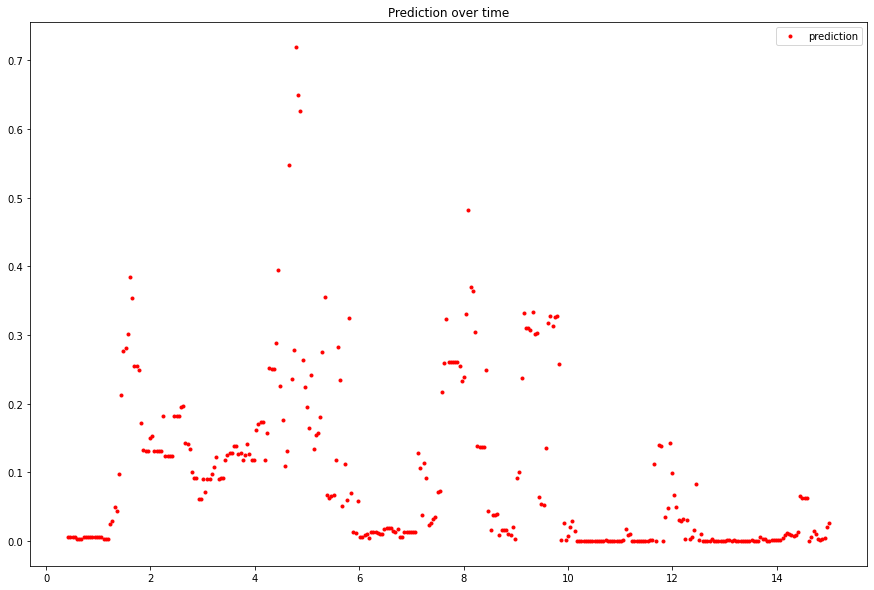

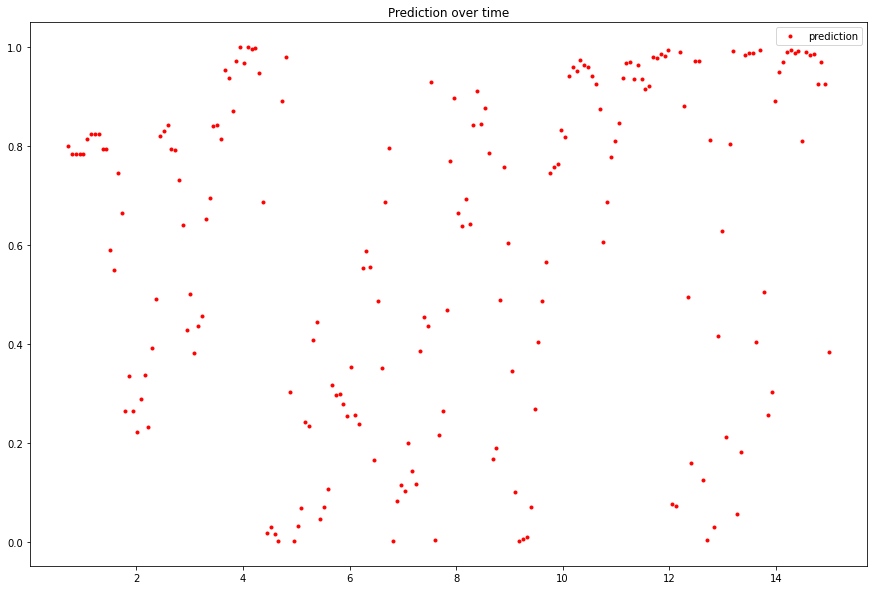

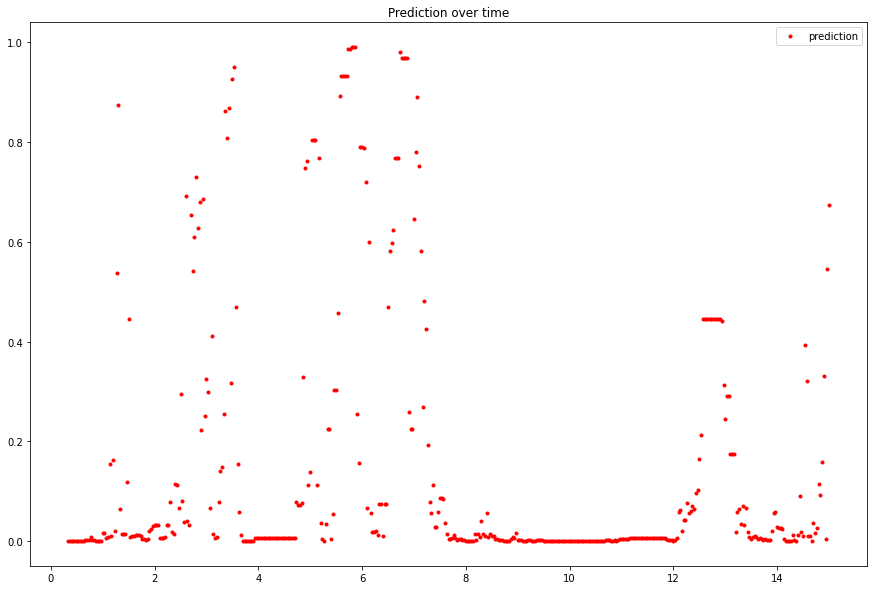

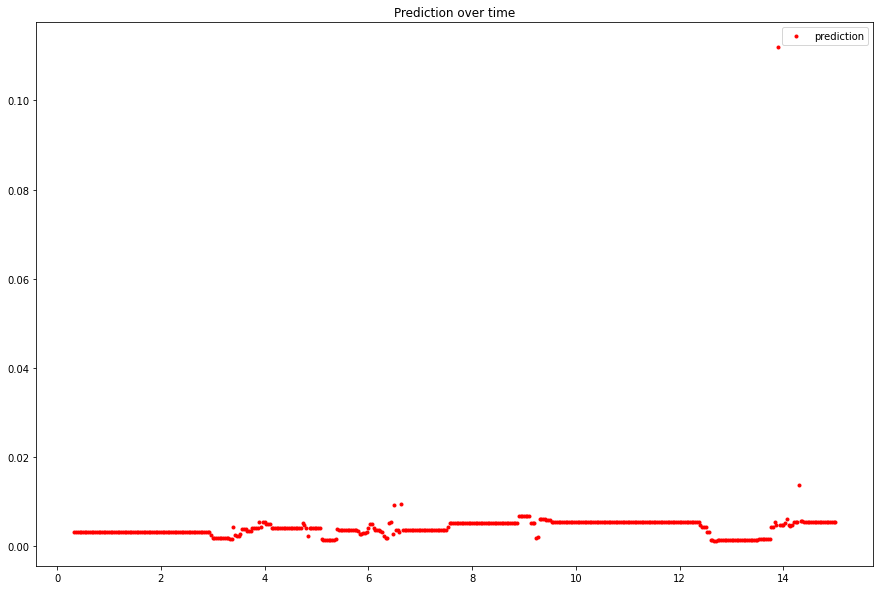

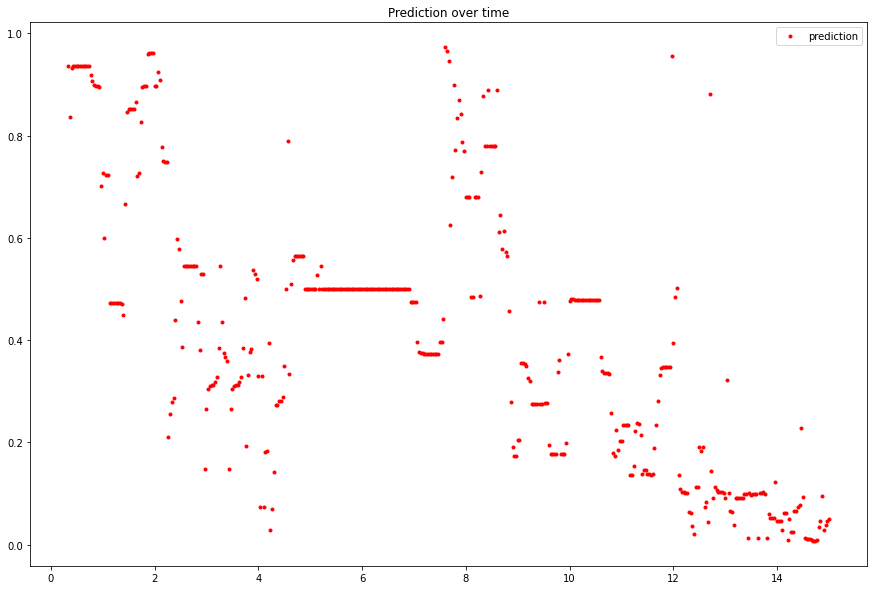

In [0]:
model = load_model('origin_rmsprop.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_segments_and_timestamps(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  drawplt(ts_arr, y_pred)
  # output json file
  json_name = 'model1_' + str(i + 1) + '.json'
  to_json(CSV_FOLDER + json_name)

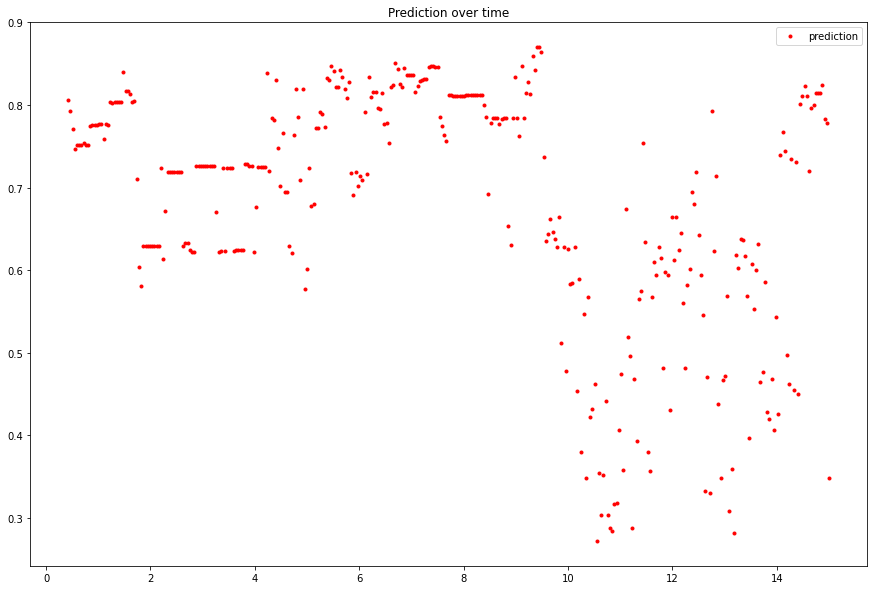

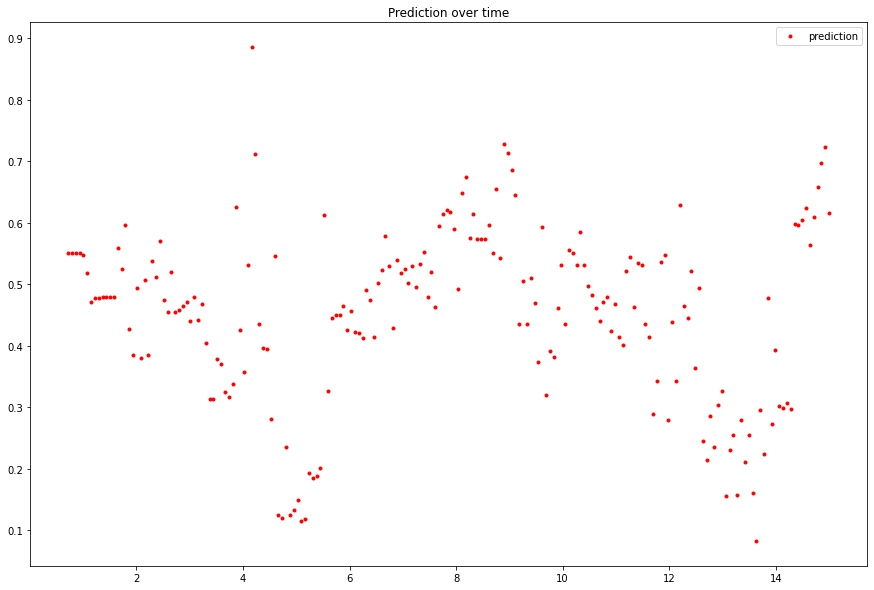

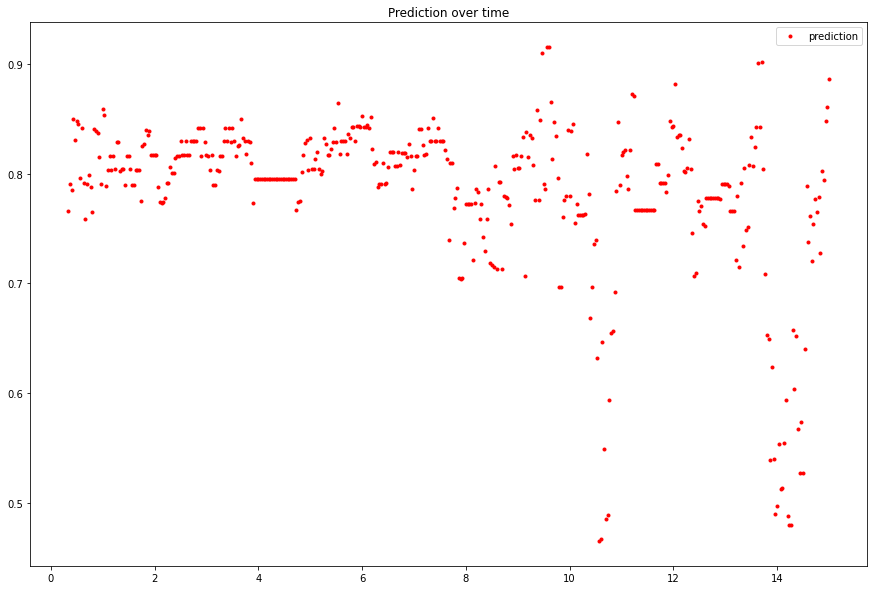

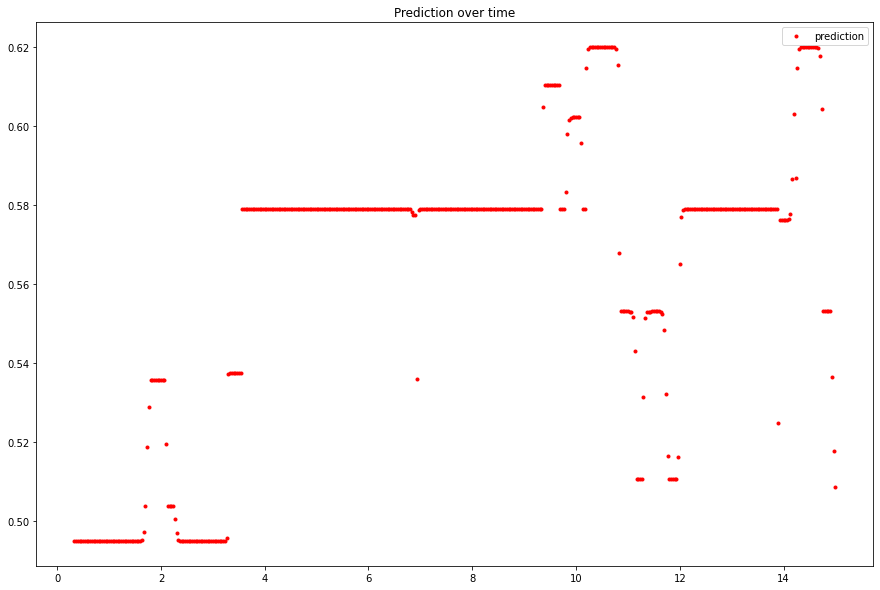

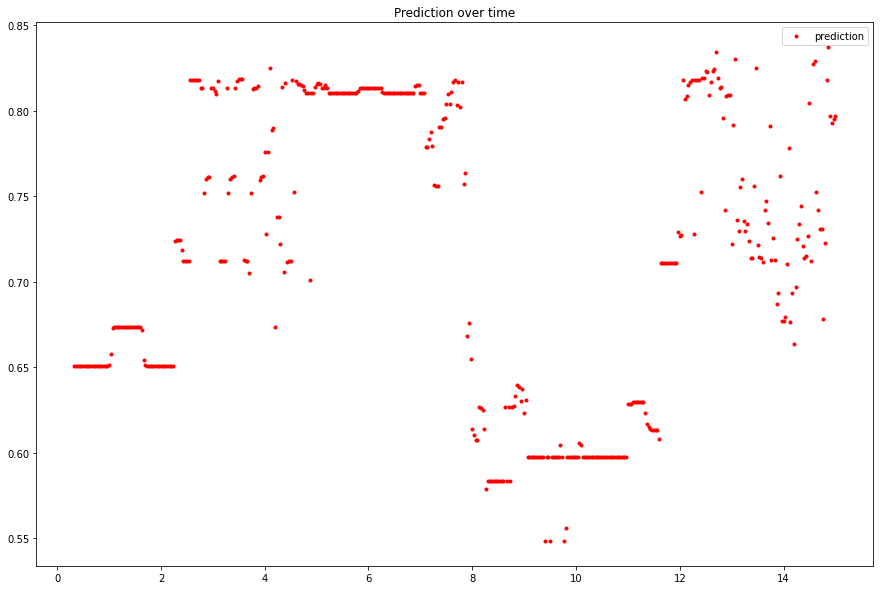

In [0]:
model = load_model('bi_rmsprop.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_segments_and_timestamps(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  drawplt(ts_arr, y_pred)
  # output json file
  json_name = 'model2_' + str(i + 1) + '.json'
  to_json(CSV_FOLDER + json_name)

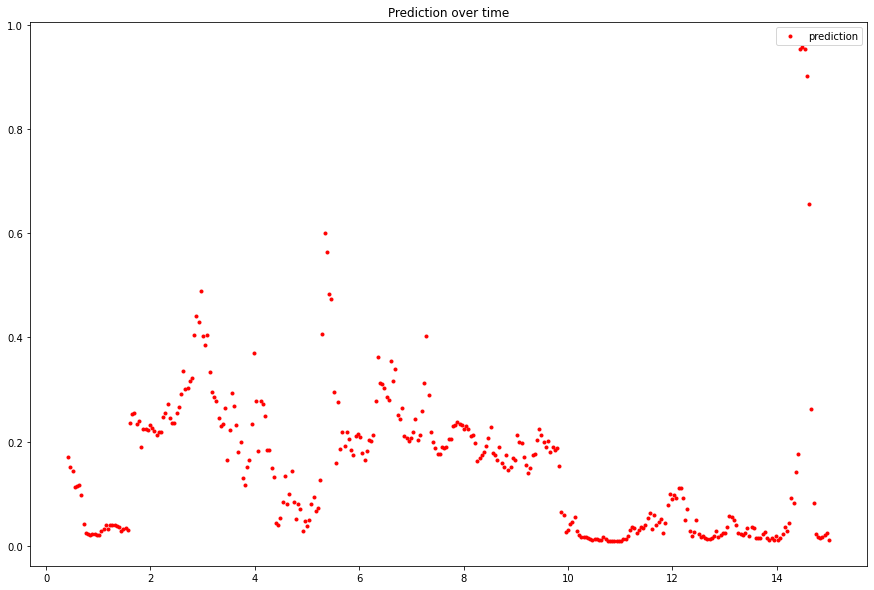

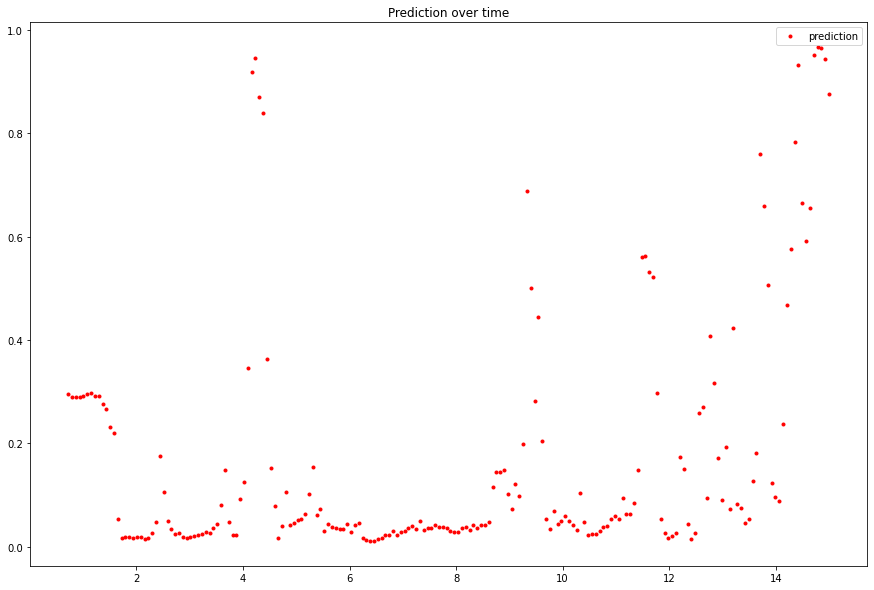

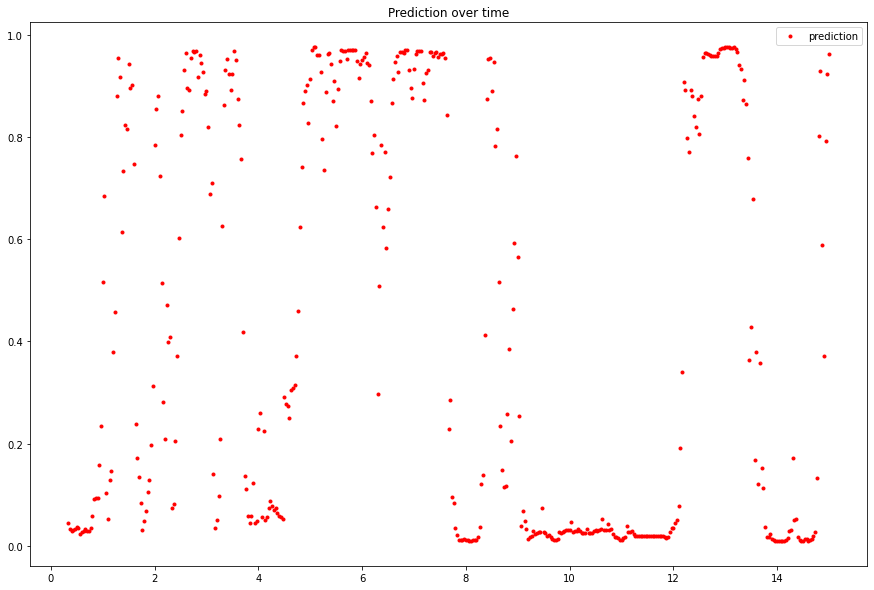

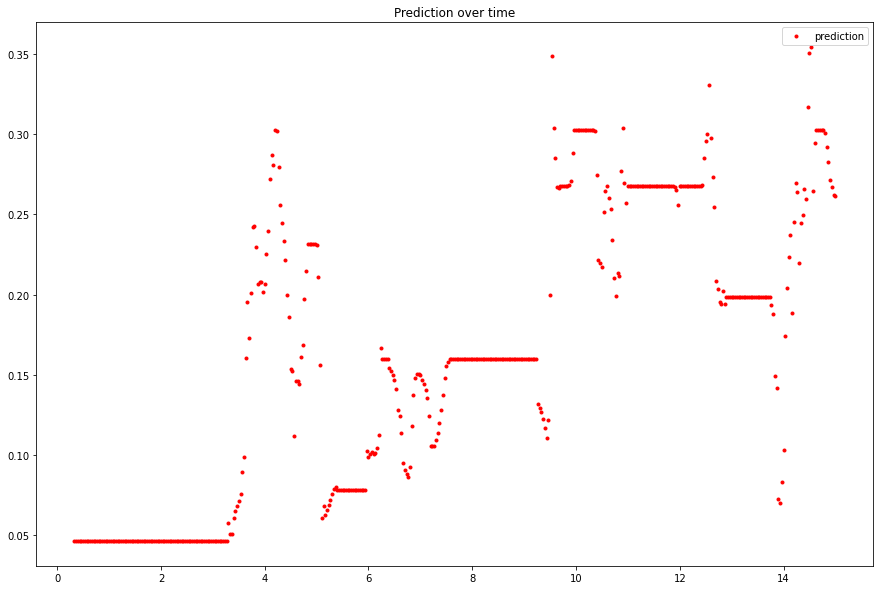

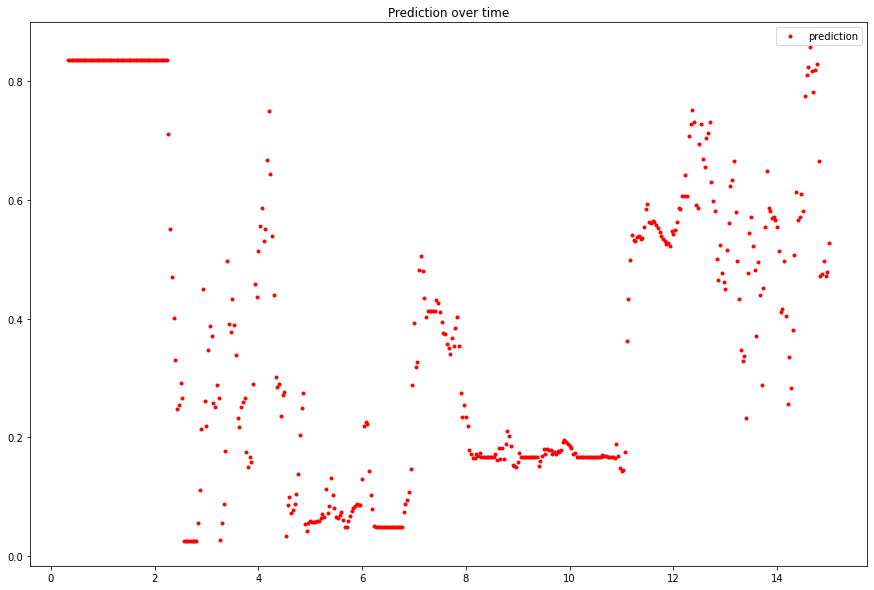

In [0]:
model = load_model('2lstm.h5')
for i in range(len(df_list)):
  # get dataframe
  df = df_list[i]
  # get input and timestamp
  t = 15.0
  frames = df.shape[0]
  fps = frames / t
  X_arr, ts_arr = get_segments_and_timestamps(df, fps, 10)
  # get prediction
  y_pred = model.predict(X_arr)
  # draw plot
  drawplt(ts_arr, y_pred)
  # output json file
  json_name = 'model3_' + str(i + 1) + '.json'
  to_json(CSV_FOLDER + json_name)

In [0]:
model = load_model('2lstm.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_5 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 76,161
Trainable params: 76,161
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = load_model('bi_rmsprop.h5')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 128)               113152    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 113,281
Trainable params: 113,281
Non-trainable params: 0
_________________________________________________________________


In [0]:
model = load_model('origin_rmsprop.h5')

In [0]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 10, 64)            10048     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 43,137
Trainable params: 43,137
Non-trainable params: 0
_________________________________________________________________
